In [ ]:
#!pip install nbdime
#!nbdime config-git --enable

In [ ]:
from read_data import CustomImageDataset, load_labels
from constants import Constants
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = CustomImageDataset(Constants.TRAIN_PATH, transform=transform)
val_dataset = CustomImageDataset(Constants.VAL_PATH, transform=transform)
test_dataset = CustomImageDataset(Constants.TEST_PATH, transform=transform)

In [3]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


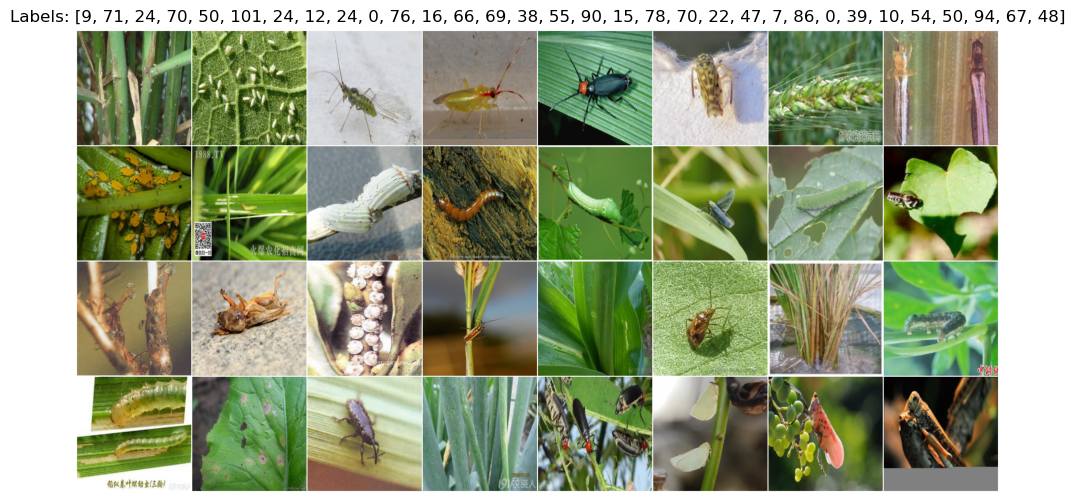

In [11]:
images, labels = next(iter(train_loader))

# Make a grid of images
grid = make_grid(images, nrow=8, normalize=True, pad_value=1)

# Convert to numpy for plotting
npimg = grid.permute(1, 2, 0).numpy()

# Plot the grid
plt.figure(figsize=(12, 6))
plt.imshow(npimg)
plt.title(f"Labels: {labels.tolist()}")
plt.axis("off")
plt.show()


In [ ]:
ids, labels = load_labels(Constants.ID_LABEL_PATH)

In [ ]:
print(dict(zip(ids[0:10],labels[0:10])))

{1: 'rice leaf roller', 2: 'rice leaf caterpillar', 3: 'paddy stem maggot', 4: 'asiatic rice borer', 5: 'yellow rice borer', 6: 'rice gall midge', 7: 'Rice Stemfly', 8: 'brown plant hopper', 9: 'white backed plant hopper', 10: 'small brown plant hopper'}


In [11]:
import torch
from transformers import Blip2Processor, Blip2ForImageTextRetrieval
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "Salesforce/blip2-flan-t5-xl"
model = Blip2ForImageTextRetrieval.from_pretrained(model_name).to(device)
processor = Blip2Processor.from_pretrained(model_name)

model.eval() 

# 3. one-time embedding for prompt
with torch.no_grad():
    class_inputs = processor(text=labels, return_tensors="pt", padding=True, truncation=True).to(device)
    class_embeddings = model.get_text_features(**class_inputs)  # [num_classes x dim]
    class_embeddings = class_embeddings / class_embeddings.norm(dim=-1, keepdim=True)  # normalize

# 4. validation loader
correct = 0
total = 0

for batch in tqdm(val_loader):
    images, labels = batch
    images = list(image.convert("RGB") for image in images)
    labels = labels.to(device)

    with torch.no_grad():
        inputs = processor(images=images, return_tensors="pt").to(device)
        image_embeddings = model.get_image_features(**inputs)  # [B x dim]
        image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)  # normalize

        # similarity: [B x num_classes]
        sims = torch.matmul(image_embeddings, class_embeddings.T)
        preds = torch.argmax(sims, dim=1)

    correct += (preds == labels).sum().item()
    total += labels.size(0)

acc = correct / total
print(f"✅ Validation Accuracy: {acc:.4f}")


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.96G [00:00<?, ?B/s]

KeyboardInterrupt: 